# Probability distribution using Oscilloscope

       Interval Start  Interval End Classification
0           -0.002080     -0.002079       1 Photon
1           -0.002079     -0.002079       1 Photon
2           -0.002079     -0.002079       1 Photon
3           -0.002079     -0.002079       1 Photon
4           -0.002079     -0.002079      0 Photons
...               ...           ...            ...
79360        0.001920      0.001920       4 Photon
79361        0.001920      0.001920       2 Photon
79362        0.001920      0.001920       3 Photon
79363        0.001920      0.001920       2 Photon
79364        0.001920      0.001920       2 Photon

[79365 rows x 3 columns]


C:\Users\dalop\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


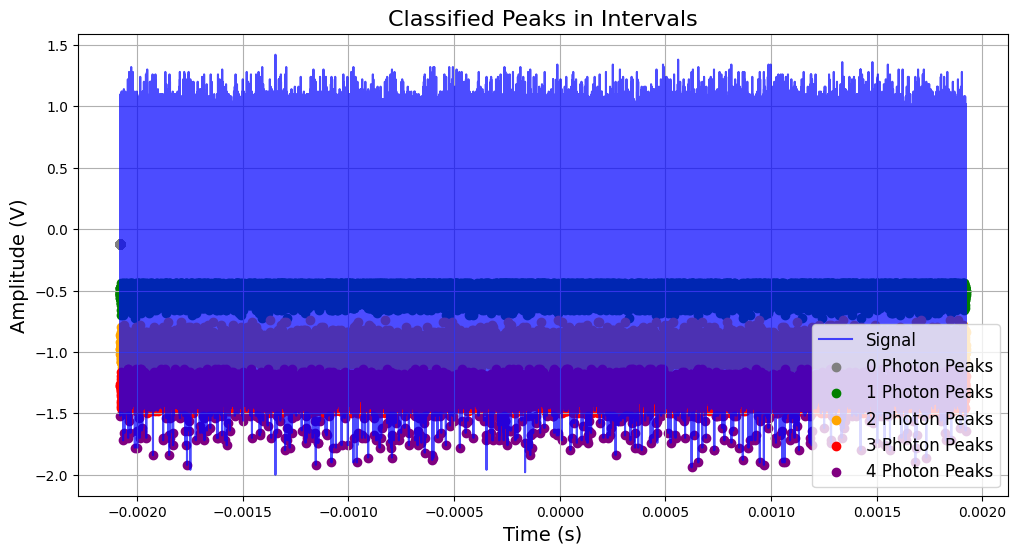

In [17]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Load the CSV file (replace with your actual file path)
file_path = 'tek0006ALL.csv'
df = pd.read_csv(file_path, skiprows=20)

# Rename columns
df.columns = ['TIME', 'CH2', 'CH3', 'CH4']

# Extract time and signal data (assuming CH4 as example)
time = df['TIME']
ch4 = df['CH4']

# Define the interval width
interval_width = 5.039999999983946e-08  # Time interval width

# Define photon ranges (in volts)
photon_ranges = {
    '1 Photon': (-0.72, -0.43),
    '2 Photon': (-1.13, -0.73),
    '3 Photon': (-1.51, -1.14),
    '4 Photon': (-1.95, -1.52),
}

# Classify peaks
classified_peaks = {'0 Photon': [],'1 Photon': [], '2 Photon': [], '3 Photon': [], '4 Photon': []}

# Create bins based on the interval width
time_min, time_max = np.min(time), np.max(time)
bins = np.arange(time_min, time_max, interval_width)

# Find peaks in the signal
peaks, _ = find_peaks(-ch4, height=0.35)

# Initialize lists to store results
classified_intervals = []

# Iterate over each interval
for i in range(len(bins) - 1):
    # Define the start and end of the interval
    start, end = bins[i], bins[i + 1]

    # Get indices of peaks within this interval
    peaks_in_interval = peaks[(time[peaks] >= start) & (time[peaks] < end)]

    # Initialize classification for the interval
    interval_classification = {'Interval Start': start, 'Interval End': end, 'Classification': '0 Photons'}

    # Check if there are peaks in the interval
    if len(peaks_in_interval) > 0:
        # Find the highest peak in the interval
        max_peak_idx = peaks_in_interval[np.argmax(ch4.iloc[peaks_in_interval])]
        max_amplitude = ch4.iloc[max_peak_idx]

        # Classify the peak based on photon ranges
        for photon, (lower, upper) in photon_ranges.items():
            if lower <= max_amplitude <= upper:
                interval_classification['Classification'] = photon
                classified_peaks[photon].append(max_peak_idx)
                break  # Stop checking after classification
    else:
        # If no peaks, classify as 0 photons
        interval_classification['Classification'] = '0 Photons'
        classified_peaks['0 Photon'].append(0)

    # Append the interval classification
    classified_intervals.append(interval_classification)


# Convert results to a DataFrame for better visualization
classified_intervals_df = pd.DataFrame(classified_intervals)

# Display results
print(classified_intervals_df)

# Optional: Plot the signal with classified peaks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time, ch4, color='blue', alpha=0.7, label='Signal')


# Plot peaks for each photon category
colors = ['gray', 'green', 'orange', 'red', 'purple']
for i, (photon, peak_indices) in enumerate(classified_peaks.items()):
    plt.scatter(time.iloc[peak_indices], ch4.iloc[peak_indices],
                label=f'{photon} Peaks', color=colors[i])

# Plot settings
plt.title('Classified Peaks in Intervals', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (V)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


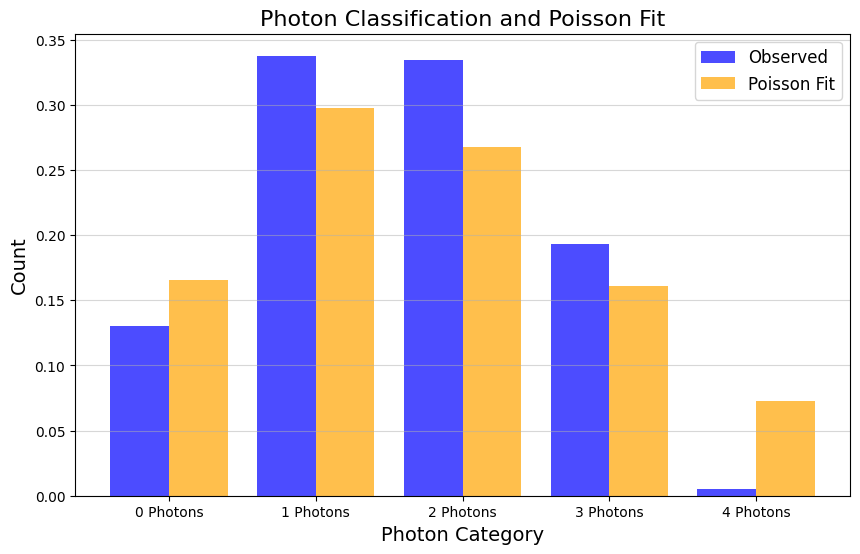

Fitted lambda (mean photon count): 1.801


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson

# Generate histogram data
photon_counts = {photon: len(indices) for photon, indices in classified_peaks.items()}

# Convert the dictionary to numeric values
categories = np.array([0, 1, 2, 3, 4])  # Numeric photon categories
counts = np.array(list(photon_counts.values())) # Observed counts
total_count = np.sum(counts)  # Total observed count
probabilities = counts/total_count

# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, probabilities , p0=[1])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, probabilities , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title('Photon Classification and Poisson Fit', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")


# Getting the $P$ matrix

In [33]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import factorial


P = np.array([
    [1, 0.076, 0.0063, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.924, 0.507, 0.260, 0.135, 0.0716, 0.0383, 0.0207, 0.0113, 0.0062],
    [0, 0, 0.487, 0.647, 0.6728, 0.6482, 0.6067, 0.5596, 0.5139, 0.4712],
    [0, 0, 0, 0.0919, 0.1858, 0.2645, 0.3275, 0.3777, 0.4177, 0.4498],
    [0, 0, 0, 0, 0.00588, 0.0157, 0.0281, 0.0419, 0.0569, 0.0767]
])

def poisson_distribution(P, tau, wavelength, max_m, duty):
    """
    Generate a Poisson distribution array.

    Parameters:
    - P: Laser power (in watts).
    - tau: Pulse duration (in seconds).
    - wavelength: Laser wavelength (in meters).
    - max_m: Maximum number of photons to compute in the distribution.

    Returns:
    - Array of probabilities for photon numbers 0 to max_m.
    """
    # Constants
    h = 6.626e-34  # Planck's constant (J·s)
    c = 3e8        # Speed of light (m/s)

    # Calculate the frequency of the laser
    nu = c / wavelength

    # Calculate the mean photon number (mu)
    P_peak = P/duty
    mu = (P_peak * tau) / (h * nu)
    # Generate the Poisson distribution
    m_values = np.arange(0, max_m)  # Photon numbers from 0 to max_m
    S_m = (mu ** m_values / factorial(m_values)) * np.exp(-mu)

    return S_m

def euclidean_norm(P_flat, Q, S, n, m):
    """
    Compute the Euclidean norm ||Q - PS||_2.

    Parameters:
    - P_flat: Flattened lower triangular matrix (optimization variable).
    - Q: Observed statistics vector (numpy array).
    - S: Input statistics vector (numpy array).
    - n: Number of pixels.
    - m: Maximum number of photons.

    Returns:
    - Euclidean norm ||Q - PS||_2.
    """
    # Reconstruct the upper triangular P matrix
    P_z = np.zeros((n, m))
    triu_indices = np.triu_indices(n, 0, m)

    # Remove P[0][0] from indices
    exclude_index = (triu_indices[0] == 0) & (triu_indices[1] == 0)
    triu_indices = (
        triu_indices[0][~exclude_index],
        triu_indices[1][~exclude_index]
    )

    P_z[triu_indices] = P_flat

    # Enforce P[0][0] = 1
    P_z[0, 0] = 1

    # Compute PS
    PS = np.dot(P_z, S)
    
    # Compute the Euclidean norm
    norm = np.linalg.norm(Q - PS, ord=2)
    return norm

def optimize_P(Q, S, n, m):
    """
    Optimize the detector response matrix P to minimize ||Q - PS||_2.

    Parameters:
    - Q: Observed statistics vector (numpy array).
    - S: Input statistics vector (numpy array).
    - n: Number of pixels.
    - m: Maximum number of photons.

    Returns:
    - Optimized detector response matrix P.
    """
    # Extract indices for the upper triangular part of the matrix
    triu_indices = np.triu_indices(n, 0, m)

    # Remove P[0][0] from indices
    exclude_index = (triu_indices[0] == 0) & (triu_indices[1] == 0)
    triu_indices = (
        triu_indices[0][~exclude_index],
        triu_indices[1][~exclude_index]
    )
    
    # Initial guess for P (flat array of upper triangular elements)
    P_initial = P[triu_indices]
    
    # Adjust bounds to match the size of the upper triangular part
    num_params = len(P_initial)
    bounds = [(0, 1) for _ in range(num_params)]
    
    # Optimization
    result = minimize(
        euclidean_norm, P_initial, args=(Q, S, n, m),
        method='L-BFGS-B', bounds=bounds
    )
    
    # Reconstruct the optimized upper triangular P matrix
    P_optimized = np.zeros((n, m))
    P_optimized[triu_indices] = result.x

    # Enforce P[0][0] = 1
    P_optimized[0, 0] = 1

    return P_optimized


# Example usage
p = 0.517404580152672e-11  # Laser average power in watts 
duty = 0.000006 # Duty cicle of the laser pulse
tau = 0.3e-12  # Pulse duration in seconds 
wavelength = 1310e-9  # Laser wavelength in meters

# Example usage
n = 5  # Number of pixels (0 to 3 clicks)
m = 10  # Maximum number of photons considered (0 to 4 photons)

# Observed statistics Q (example)
Q = probabilities

# Input statistics S (Poisson distribution with mean photon number)
S = poisson_distribution(p, tau, wavelength, m, duty)
print("Poisson Distribution:", S)

# Optimize P
P_optimized = optimize_P(Q, S, n, m)
print("Optimized P:\n", P_optimized)

#triu_indices = np.triu_indices(5, 0, 10)
#p_T = P[triu_indices]

#eu = euclidean_norm(p_T.flatten(), Q, S, n, m)
#print(eu)


Poisson Distribution: [1.81790584e-01 3.09934747e-01 2.64203858e-01 1.50147043e-01
 6.39964192e-02 2.18214976e-02 6.20057814e-03 1.51019500e-03
 3.21841411e-04 6.09674873e-05]
Optimized P:
 [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.71165085 0.325983   0.15712808 0.09115344 0.0566492
  0.03405173 0.0196653  0.0110795  0.00615823]
 [0.         0.         0.61444732 0.71942835 0.70367079 0.65872632
  0.60969105 0.56032849 0.51405525 0.47122941]
 [0.         0.         0.         0.93152768 0.6409813  0.41970772
  0.37160227 0.38844143 0.41998914 0.45023364]
 [0.         0.         0.         0.         0.05893234 0.03378978
  0.03324021 0.04315193 0.0571668  0.07675054]]


# Reconstruction of the probability distribution

Truncated and Non-Negative S (size 5): [0.12991386 0.30498131 0.27415282 0.15121577 0.08149487]


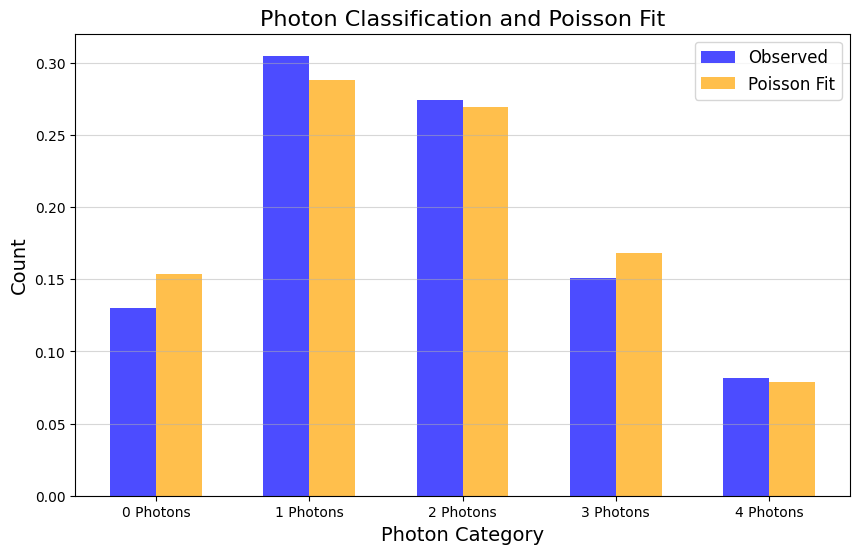

Fitted lambda (mean photon count): 1.872


In [ ]:
from scipy.optimize import nnls

def truncate_and_nnls(P, Q, k):
    """
    Truncate P to a k x k matrix and solve for S using non-negative least squares.

    Parameters:
    - P: Transition matrix (2D numpy array).
    - Q: Observed statistics vector (1D numpy array).
    - k: Size to truncate P to (integer).

    Returns:
    - Non-negative solution S for the truncated system.
    """
    # Truncate P to a k x k matrix
    P_truncated = P[:k, :k]
    Q_truncated = Q[:k]

    # Solve using NNLS
    S_truncated, _ = nnls(P_truncated, Q_truncated)

    return S_truncated

# Example usage
k = 5
S_truncated_nnls = truncate_and_nnls(P_optimized, probabilities, k)

print(f"Truncated and Non-Negative S (size {k}):", S_truncated_nnls)


# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, S_truncated_nnls , p0=[1])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, S_truncated_nnls , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title('Photon Classification and Poisson Fit', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")


